### Image Captioning

Code adapted from https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning

In [86]:
%pip install pytorch-beam-search
%pip install nltk

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.2/763.2 KB 164.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [179]:
import os
import numpy as np
import h5py
import json
import torch
import imageio
#from imageio import imread, imresize
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from torchvision import models
from torch import nn
from torchsummary import summary
from torch.nn.utils.rnn import pack_padded_sequence
from pytorch_beam_search import autoregressive
import torchextractor as tx

In [150]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [151]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

## 1. Create HDF5 File and the relative Dataset

In [152]:
def create_input_files(dataset, karpathy_json_path, image_folder, captions_per_image, min_word_freq, output_folder,
                       max_len=100):
    """
    Creates input files for training, validation, and test data.
    :param dataset: name of dataset, one of 'coco', 'flickr8k', 'flickr30k'
    :param karpathy_json_path: path of Karpathy JSON file with splits and captions
    :param image_folder: folder with downloaded images
    :param captions_per_image: number of captions to sample per image
    :param min_word_freq: words occuring less frequently than this threshold are binned as <unk>s
    :param output_folder: folder to save files
    :param max_len: don't sample captions longer than this length
    """

    assert dataset in {'coco', 'flickr8k', 'flickr30k'}

    # Read Karpathy JSON
    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)

    # Read image paths and captions for each image
    train_image_paths = []
    train_image_captions = []
    val_image_paths = []
    val_image_captions = []
    test_image_paths = []
    test_image_captions = []
    word_freq = Counter()

    for img in data['images']:
        captions = []
        for c in img['sentences']:
            # Update word frequency
            word_freq.update(c['tokens'])
            if len(c['tokens']) <= max_len:
                captions.append(c['tokens'])

        if len(captions) == 0:
            continue

        path = os.path.join(image_folder, img['filepath'], img['filename']) if dataset == 'coco' else os.path.join(
            image_folder, img['filename'])

        if img['split'] in {'train', 'restval'}:
            train_image_paths.append(path)
            train_image_captions.append(captions)
        elif img['split'] in {'val'}:
            val_image_paths.append(path)
            val_image_captions.append(captions)
        elif img['split'] in {'test'}:
            test_image_paths.append(path)
            test_image_captions.append(captions)

    # Sanity check
    assert len(train_image_paths) == len(train_image_captions)
    assert len(val_image_paths) == len(val_image_captions)
    assert len(test_image_paths) == len(test_image_captions)

    # Create word map
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
    word_map = {k: v + 1 for v, k in enumerate(words)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0

    # Create a base/root name for all output files
    base_filename = dataset + '_' + str(captions_per_image) + '_cap_per_img_' + str(min_word_freq) + '_min_word_freq'
    
    os.makedirs(output_folder,exist_ok=True)
    
    # Save word map to a JSON
    with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
        json.dump(word_map, j)

    # Sample captions for each image, save images to HDF5 file, and captions and their lengths to JSON files
    seed(123)
    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                   (val_image_paths, val_image_captions, 'VAL'),
                                   (test_image_paths, test_image_captions, 'TEST')]:

        with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
            # Make a note of the number of captions we are sampling per image
            h.attrs['captions_per_image'] = captions_per_image

            # Create dataset inside HDF5 file to store images
            images = h.create_dataset('images', (len(impaths), 3, 256, 256), dtype='uint8')

            print("\nReading %s images and captions, storing to file...\n" % split)

            enc_captions = []
            caplens = []

            for i, path in enumerate(tqdm(impaths)):

                # Sample captions
                if len(imcaps[i]) < captions_per_image:
                    captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
                else:
                    captions = sample(imcaps[i], k=captions_per_image)

                # Sanity check
                assert len(captions) == captions_per_image

                # Read images
                img = Image.open(impaths[i])
                img=img.resize((256,256))
                img=np.array(img)
                if len(img.shape) == 2:
                    img = img[:, :, np.newaxis]
                    img = np.concatenate([img, img, img], axis=2)
                #img = imresize(img, (256, 256))
                img = img.transpose(2, 0, 1)
                assert img.shape == (3, 256, 256)
                assert np.max(img) <= 255

                # Save image to HDF5 file
                images[i] = img

                for j, c in enumerate(captions):
                    # Encode captions
                    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                        word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))

                    # Find caption lengths
                    c_len = len(c) + 2

                    enc_captions.append(enc_c)
                    caplens.append(c_len)

            # Sanity check
            assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)

            # Save encoded captions and their lengths to JSON files
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
                json.dump(enc_captions, j)

            with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
                json.dump(caplens, j)


In [153]:
create=False

if create:
    
    json_path="/space/matteo/BOLD5000/COCO/dataset_coco.json"

    create_input_files('coco',
                   json_path, 
                   "/space/matteo/BOLD5000/COCO",
                    output_folder="/space/matteo/BOLD5000/COCO/hdf5",
                    captions_per_image=5,
                    min_word_freq=10,
                    max_len=50)



## 2. Create CaptionDataset

In [154]:
class CaptionDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, data_name, split, transform=None):
        """
        :param data_folder: folder where data files are stored
        :param data_name: base name of processed datasets
        :param split: split, one of 'TRAIN', 'VAL', or 'TEST'
        :param transform: image transform pipeline
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        # Open hdf5 file where images are stored
        self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
        self.imgs = self.h['images']

        # Captions per image
        self.cpi = self.h.attrs['captions_per_image']

        # Load encoded captions (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
            self.captions = json.load(j)

        # Load caption lengths (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
            self.caplens = json.load(j)

        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.captions)

    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the (N // captions_per_image)th image
        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])

        caplen = torch.LongTensor([self.caplens[i]])

        if self.split == 'TRAIN':
            return img, caption, caplen
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions

    def __len__(self):
        return self.dataset_size

In [155]:
def get_sentence(caption,word_map):
    return [word_map[x.item()] for x in caption]

def get_clean_sentence(caption,word_map):
    s=get_sentence(caption,word_map)
    s=[i for i in s[1:] if i!="<pad>"]
    return s[:-1]

In [156]:
# Custom dataloaders


batch_size=128
data_folder="/space/matteo/BOLD5000/COCO/hdf5"
data_name="coco_5_cap_per_img_10_min_word_freq"

word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)

revese_word_map={v:k for k,v in word_map.items()}

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
train_dataset=CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize]))
val_dataset=CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize]))
test_dataset=CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize]))

train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader=torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)


In [157]:
img, caption, caplen = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


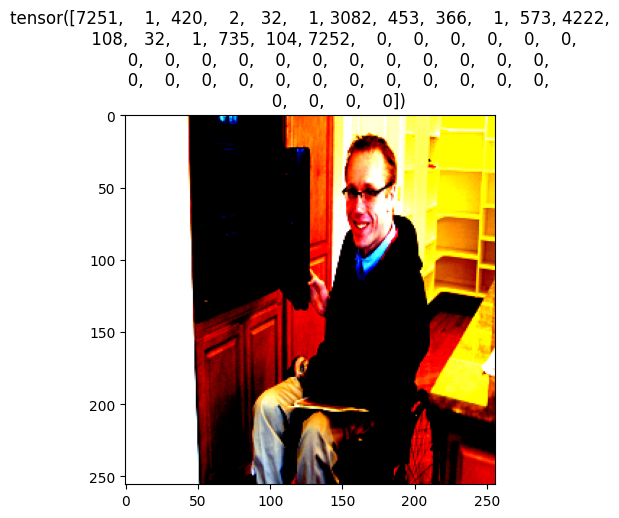

<start> a smiling man in a wheelchair looks inside a well positioned oven in a new kitchen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [158]:
idx=0
plt.title(caption[idx])
plt.imshow(img[idx].permute(1,2,0))
plt.show()
print(" ".join(get_sentence(caption[idx],revese_word_map)))



In [ ]:
#get_sentence(caption,revese_word_map)

## Networks block

Encoder (Resnet) freeze

Decoder with attention (LSTM or GRU)

### Encoder

In [195]:
class Encoder(nn.Module):
    def __init__(self,out_size=7):
        super().__init__()
        
        

        model = models.resnet50(pretrained=True)
        #self.model = tx.Extractor(model, ["Mixed_7c"])
        #model=models.resnet101(pretrained=True)
        modules=list(model.children())[:-2] #remove avgpool and fc
        self.model=nn.Sequential(*modules)

        #self.avgpool=nn.AdaptiveAvgPool2d(output_size=out_size)

        ##freeze all pretrained model weights

        for param in self.model.parameters():
            param.requires_grad=False

    def forward(self,x):
        
        #_,feat=self.model(x)
        #x=feat["Mixed_7c"]
        x=self.model(x)
        #x=self.avgpool(x)
        return x

In [196]:
encoder=Encoder()

summary(encoder,(3,224,224),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Decoder

In [197]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        
        super().__init__()
         
        self.encoder_att=nn.Linear(encoder_dim,attention_dim)
        self.decoder_att=nn.Linear(decoder_dim,attention_dim)
        self.value=nn.Linear(attention_dim,1)
        self.act=nn.ReLU()
        self.softmax=nn.Softmax(dim=1)
    
    def forward(self,encoder_out,decoder_hidden):
        
        
        e=self.encoder_att(encoder_out)  ##encoder out should be (bs,num_pixel,enc_dim) so it became (bs, num_pixel, attn_dim)
        d=self.decoder_att(decoder_hidden).unsqueeze(1) #output should be (bs,1,att_dim)

        

        score=self.value(self.act(e+d)).squeeze(-1) #output will (bs,num_pixel)

        
        attention_weights=self.softmax(score)

        
        context=attention_weights.unsqueeze(-1)*encoder_out #this is (bs,num_pixel,1)*(bs,num_pixel,encoder_dim)


        context=context.sum(dim=1) #this output will be (bs,encoder_dim)
        

        return context,attention_weights



In [198]:
class Decoder(nn.Module):
    def __init__(self,att_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=512, dropout=0.5):
        
        super().__init__()

        self.encoder_dim=encoder_dim
        self.vocab_size=vocab_size

        self.attention=Attention(encoder_dim=encoder_dim,decoder_dim=decoder_dim,attention_dim=att_dim)
        self.embedding=nn.Embedding(vocab_size,embedding_dim=embed_dim) #embed words into vectors

        self.decode=nn.LSTMCell(embed_dim+encoder_dim,decoder_dim,bias=True) #lstm take concat of word and image data
        self.dropout=nn.Dropout(dropout)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary



    def init_hidden_state(self, encoder_out):

        mean_encoder_out = encoder_out.mean(dim=1) #mean over pixel
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self,encoder_out,encoded_captions,caplen):

        bs=encoder_out.shape[0]
        

        


        encoder_out = encoder_out.view(bs, -1, self.encoder_dim) #should be (bs,num_pixel,encoder_dim)
        num_pixels=encoder_out.shape[1]
        
        
        #trick to order images according their lenght
        
        caption_lenghts,sort_idx=caplen.squeeze(1).sort(dim=0,descending=True)
        encoder_out=encoder_out[sort_idx]
        encoded_captions=encoded_captions[sort_idx]
        

        #embed
        embeddings = self.embedding(encoded_captions) #should be (bs,max_len,embed_dim)

        #init rnn
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        
        #extra trick to not decode <end>
        
        decode_lengths = (caption_lenghts - 1).tolist()
        
        predictions = torch.zeros(bs, max(decode_lengths), self.vocab_size,device=encoder_out.device)
        alphas = torch.zeros(bs, max(decode_lengths), num_pixels,device=encoder_out.device)



        for t in range(max(decode_lengths)):
            
            #another trick to decode only real positions and not padded ones
            
            batch_size_t = sum([l > t for l in decode_lengths])

            #pay attention
            attention_weighted_encoding, attn_weights=self.attention(encoder_out[:batch_size_t],h[:batch_size_t])

            #gate channel
            gate=self.sigmoid(self.f_beta(h[:batch_size_t]))

            attention_weighted_encoding=gate*attention_weighted_encoding


            h,c =self.decode(torch.cat([embeddings[:batch_size_t,t,:],attention_weighted_encoding],dim=1),(h[:batch_size_t],c[:batch_size_t]))

            pred = self.fc(self.dropout(h))


            predictions[:batch_size_t,t,:]=pred
            alphas[:batch_size_t,t,:]=attn_weights

        return predictions, encoded_captions, decode_lengths, alphas, sort_idx

In [191]:
vocab_len=len(word_map.keys())
print(vocab_len)

7253


In [199]:
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5

decoder=Decoder(att_dim=attention_dim,decoder_dim=decoder_dim,embed_dim=emb_dim,vocab_size=vocab_len,encoder_dim=512)

In [200]:
x,c,l=next(iter(train_dataloader))
encoder_out=encoder(x)
preds, encoded_captions, decode_lengths, alphas, sort_idx=decoder(encoder_out,c,l)
print(encoder_out.shape,preds.shape,alphas.shape)

torch.Size([128, 2048, 8, 8]) torch.Size([128, 19, 7253]) torch.Size([128, 19, 256])


### Training function

In [201]:
def train(train_dataloader,encoder,decoder,criterion,encoder_optimizer=None,decoder_optimizer=None,device="cuda",alpha_c=1.,grad_clip=5.):

    encoder.train()
    decoder.train()
    pbar=tqdm(train_dataloader)
    loss_tmp=[]
    for x,c,l in pbar:
        
        #move to gpu if available
        x,c,l=x.to(device),c.to(device),l.to(device)

        #encode images
        z=encoder(x)
        
        #preds,alphas=decoder(x,c,l) #not super sure about c and l
        preds, caps_sorted, decode_lengths, alphas, sort_ind = decoder(z, c, l)
        
        targets = caps_sorted[:, 1:]
        
        
        #preds = torch.Tensor(pack_padded_sequence(preds, l.squeeze().cpu(), batch_first=True,enforce_sorted=False))
        #targets = torch.Tensor(pack_padded_sequence(c, l.squeeze().cpu(), batch_first=True,enforce_sorted=False))
         
        #print(preds.shape,max(l),c.shape,c[:,:max(l).item()].shape)

#         loss=0.

#         for i in range(max(l).item()):
#             loss+=criterion(preds[:,i,:], c[:,i])
        
        scores,_,_,_ = pack_padded_sequence(preds, decode_lengths, batch_first=True)
        targets,_,_,_ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores, targets)


        # Calculate loss
        #loss = criterion(preds, c[:,:max(l).item()])

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        pbar.set_description(f"[LOSS]: {loss.item()}")
        loss_tmp.append(loss.item())

In [206]:
EPOCHS=60
decoder_optimizer=torch.optim.Adam(decoder.parameters(),lr=1e-4)

criterion=nn.CrossEntropyLoss()

device="cuda:1"

encoder=encoder.to(device)
decoder=decoder.to(device)

In [ ]:

loss_history=[]
for epoch in range(EPOCHS):
    loss=train(train_dataloader=train_dataloader,encoder=encoder,decoder=decoder,criterion=criterion,decoder_optimizer=decoder_optimizer,device=device)
    loss_history.append(loss)
    
    if epoch%10==0:
        torch.save(decoder.state_dict(),f"decoder_{epoch}.pt")
        torch.save(encoder.state_dict(),"decoder.pt")


[LOSS]: 7.110696792602539:   1%|          | 39/4426 [00:25<44:52,  1.63it/s] 

In [208]:
epoch

26

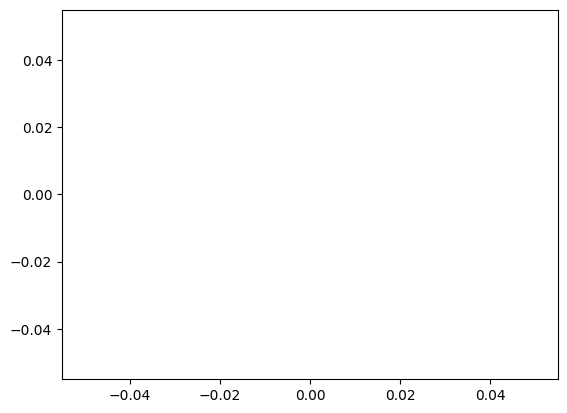

In [209]:
plt.plot(loss_history)
plt.show()

### Test del modello

In [210]:
class Image2CaptionModel(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self,x):
        z=encoder(x)
        preds, caps_sorted, decode_lengths, alphas, sort_ind =decoder(z,c,l) #not super sure about c and l
        return preds

In [211]:
model=Image2CaptionModel(encoder,decoder)

In [212]:
x,c,l,a=next(iter(val_dataloader))

x,c,l=x.to(device),c.to(device),l.to(device)

In [213]:
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [214]:
# beam search
def beam_search_decoder(post, k):
    """Beam Search Decoder

    Parameters:

        post(Tensor) – the posterior of network.
        k(int) – beam size of decoder.

    Outputs:

        indices(Tensor) – a beam of index sequence.
        log_prob(Tensor) – a beam of log likelihood of sequence.

    Shape:

        post: (batch_size, seq_length, vocab_size).
        indices: (batch_size, beam_size, seq_length).
        log_prob: (batch_size, beam_size).

    Examples:

        >>> post = torch.softmax(torch.randn([32, 20, 1000]), -1)
        >>> indices, log_prob = beam_search_decoder(post, 3)

    """

    batch_size, seq_length, _ = post.shape
    log_post = post.log()
    log_prob, indices = log_post[:, 0, :].topk(k, sorted=True)
    indices = indices.unsqueeze(-1)
    for i in range(1, seq_length):
        log_prob = log_prob.unsqueeze(-1) + log_post[:, i, :].unsqueeze(1).repeat(1, k, 1)
        log_prob, index = log_prob.view(batch_size, -1).topk(k, sorted=True)
        indices = torch.cat([indices, index.unsqueeze(-1)], dim=-1)
    return indices, log_prob


In [215]:
with torch.no_grad():
    z=encoder(x)
    preds, caps_sorted, decode_lengths, alphas, sort_ind =decoder(z,c,l) #not super sure about c and l

In [216]:
preds.shape

torch.Size([128, 21, 7253])

In [217]:
indices,log_prob=beam_search_decoder(nn.functional.softmax(preds,dim=-1),3)

In [218]:
beam_preds=indices[:,0,:]
beam_preds.shape

torch.Size([128, 21])

In [219]:
preds_arg=preds.argmax(dim=-1)
preds_arg.shape

torch.Size([128, 21])

In [78]:
# preds=preds.argmax(dim=-1)

In [220]:


# plt.imshow(img[0].cpu().permute(1,2,0))
# print(" ".join(get_clean_sentence(c[idx],revese_word_map)))
# print(" ".join(get_clean_sentence(preds[idx],revese_word_map)))
# plt.show()

In [221]:
def visualize_attention(img,att_map,title,ax):
    attn_big=torch.nn.functional.interpolate(att_map,(224,224),mode="bicubic").squeeze()
    ax.set_title(title)
    ax.imshow(img)
    ax.imshow(attn_big,alpha=0.5)
    
    

REAL: a bathroom with only a toilet a pipe a jug and a trash bin
GREEDY: cat with a a toilet and sink and sink and a window can
BEAM 1: cat with a a toilet and sink and sink and a window can <end> man man man man man


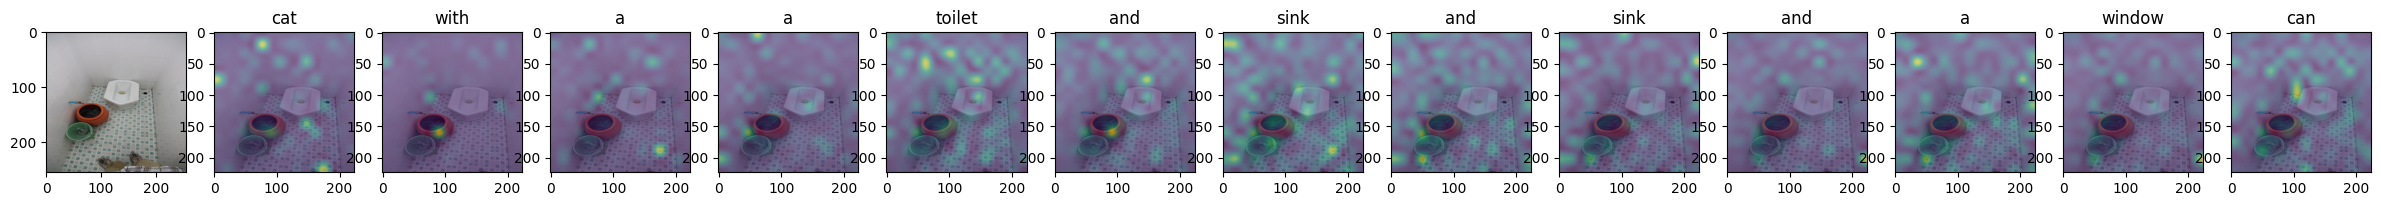

In [231]:
prediction_type="beam" #or greedy

if prediction_type=="beam":
    final_preds=beam_preds

if prediction_type=="greedy":
    final_preds=preds_arg

idx=6

sort_idx=sort_ind[idx]
img=unorm(x[sort_idx])

words=get_clean_sentence(final_preds[idx],revese_word_map)
real_words=get_clean_sentence(c[sort_idx],revese_word_map)

try:
    end_idx=words.index('<end>')
except:
    end_idx=len(words)
words=words[:end_idx]

fig,axs=plt.subplots(1,end_idx+1,figsize=(30,20))

axs[0].imshow(img.cpu().permute(1,2,0))

for i,ax in enumerate(axs[1:]):
    visualize_attention(img.cpu().permute(1,2,0),alphas[idx,i,:].cpu().reshape((1,1,16,16)),title=words[i],ax=ax)

#

print("REAL:" , " ".join(real_words))
print("GREEDY:", " ".join(get_clean_sentence(preds_arg[idx],revese_word_map)))
print("BEAM 1:", " ".join(get_clean_sentence(indices[idx,0,:],revese_word_map)))
#print("BEAM 2:", " ".join(get_clean_sentence(indices[idx,1,:],revese_word_map)))
#print("BEAM 3:", " ".join(get_clean_sentence(indices[idx,2,:],revese_word_map)))

plt.show()
